In [ ]:
%cd ~/covariate-dependent-graphical-model

In [2]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch.utils.data import DataLoader

In [3]:
from utils.utils_eval import get_heatmap, get_network_metrics_snapshots
from utils import utils_train
from utils.datasets import RealDatasetWithCovariates
from utils.utils_logging import get_logger
logger = get_logger()

In [4]:
output_dir = 'output/brain'
os.makedirs(output_dir, exist_ok=True)

LOAD_SAVED_MODEL = False
ckpt_dir = 'ckpts'
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, f'model_checkpoint_fmri.pth')

# 0. Load data and some basic data prep

In [5]:
data_str = 'p1' ## or p2

In [6]:
seed = 1001
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
data = np.load(f'data/brain/data_{data_str}.npz', allow_pickle=True)
print(data.files)

['ids', 'labels', 'label_names', 'map_names', 'x', 'z_ids', 'z_scores', 'submap_node', 'submap_network']


In [8]:
num_nodes = data['labels']

In [9]:
scores = np.array(data['z_scores'],dtype=np.float32)
score_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(scores.reshape(-1,1))
scores = score_scaler.transform(scores.reshape(-1,1)).flatten()

In [10]:
num_subjects, num_nodes, num_pts = data['x'].shape
num_pts_train, num_pts_val = 800, 200
num_pts_test = num_pts - num_pts_train - num_pts_val

x_train_raw, x_val_raw = data['x'][:,:,:num_pts_train], data['x'][:,:,num_pts_train:(num_pts_train+num_pts_val)] 
x_test_raw = data['x'][:,:,-num_pts_test:]

In [11]:
x_train_raw.shape, x_val_raw.shape, x_test_raw.shape

((549, 268, 800), (549, 268, 200), (549, 268, 200))

In [12]:
x_train = x_train_raw.transpose(0,2,1).reshape(-1, num_nodes)
x_val = x_val_raw.transpose(0,2,1).reshape(-1, num_nodes)
x_test = x_test_raw.transpose(0,2,1).reshape(-1, num_nodes)

In [13]:
x_scaler = StandardScaler().fit(np.concatenate([x_train, x_val],axis=0))
x_train, x_val, x_test = x_scaler.transform(x_train), x_scaler.transform(x_val), x_scaler.transform(x_test)

In [14]:
z_train = np.repeat(scores, x_train_raw.shape[-1]).reshape(-1,1)
z_val = np.repeat(scores, x_val_raw.shape[-1]).reshape(-1,1)
z_test = np.repeat(scores, x_test_raw.shape[-1]).reshape(-1,1)

# 1. Set up configs and create dataloaders

In [15]:
network_configs = {
    'model_name': 'dnnCGM', 
    'num_nodes': num_nodes, 
    'num_covariates': 1, 
    'beta_hidden_dims': 64, 
    'beta_dropout': 0.3, 
    'beta_batch_norm': False,
    'beta_bias': False
}

opt_configs = {
    'learning_rate': 0.0005, 
    'scheduler_type': 'StepLR', 
    'step_size': 20, 
    'gamma': 0.25
}

train_configs = {
    'max_epochs': 50, 
    'gradient_clip_val': 1.0, 
    'limit_val_batches': 50, 
    'batch_size': 1024, 
    'verbose': 20, 
    'es_patience': None, 
    'es_monitor': 'val_loss'
}

In [16]:
utils_train.fix_seed(seed)

In [17]:
train_dataset = RealDatasetWithCovariates(x=x_train, z=z_train)
val_dataset = RealDatasetWithCovariates(x=x_val, z=z_val)
test_dataset = RealDatasetWithCovariates(x=x_test, z=z_test)

In [18]:
train_dl = DataLoader(train_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=True, drop_last=True, persistent_workers=False)
val_dl = DataLoader(val_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=False, drop_last=True, persistent_workers=False)
test_dl = DataLoader(test_dataset, batch_size=1024, num_workers=4, shuffle=False, drop_last=False, persistent_workers=False)

In [19]:
len(train_dl), len(val_dl), len(test_dl)

(428, 107, 108)

# 2. Train the model

In [20]:
model, optimizer, scheduler = utils_train.initialize_model_and_optimizer(network_configs,
                                                                         opt_configs,
                                                                         device)

2025-04-22 14:14:38;INFO;utils_train:74 - model dnnCGM initialized on device cuda:1


total number of parameters: 4,583,808


In [21]:
if LOAD_SAVED_MODEL:
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    logger.info(f'model loaded from {ckpt_path}')
else:
    utils_train.model_fit(model, optimizer, scheduler, train_configs, train_dl, val_dl, output_dir, use_meter=False)
    checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, ckpt_path)
    logger.info(f'model saved to {ckpt_path}')

>> Epoch=001, lr=5.0E-04; train_loss=0.7344; val_loss=0.6757; [timer=8s/epoch]
>> Epoch=020, lr=1.3E-04; train_loss=0.6381; val_loss=0.6642; [timer=8s/epoch]
>> Epoch=040, lr=3.1E-05; train_loss=0.6359; val_loss=0.6634; [timer=8s/epoch]


2025-04-22 14:21:28;INFO;utils_train:230 - model training completed; total time elapsed = 6.82 mins
2025-04-22 14:21:28;INFO;2788002469:10 - model saved to ckpts/model_checkpoint_fmri.pth


## 2.0 predict on test set

In [22]:
%%time
preds, graphs = utils_train.model_predict(model, test_dl)
graphs.shape

CPU times: user 2min 16s, sys: 52.8 s, total: 3min 9s
Wall time: 23.9 s


(109800, 268, 268)

In [23]:
graphs_reshaped = graphs.reshape(num_subjects, num_pts_test, num_nodes, num_nodes)
graphs_by_subject = graphs_reshaped[:,0,:,:]
np.save(f'{output_dir}/graphs_by_subject_{data_str}.npy', graphs_by_subject)

## 2.1 gather results by sub-network/score

In [24]:
submap = pd.DataFrame()
submap['node'], submap['network'] = data['submap_node'], data['submap_network']
submap['network'] = submap['network'].astype(int)
submap['network_name'] = submap['network'].apply(lambda x: data['map_names'][x-1])

def get_node_id_by_region(network_name, submap):
    ## convert to 0-index
    node_ids = [node_id - 1 for node_id in submap.loc[submap['network_name']==network_name,'node'].tolist()]
    return node_ids

In [25]:
graphs_by_subject = np.load(f'{output_dir}/graphs_by_subject_{data_str}.npy')
graphs_by_subject.shape

(549, 268, 268)

In [26]:
score_cut = list(np.quantile(scores,q=[0.25,0.50,0.75,1.0]))
score_cut = [(min(scores)-1 if i == 0 else score_cut[i-1], score_cut[i]) for i in range(len(score_cut))] 

In [27]:
labelmap = pd.DataFrame()
labelmap['node_label'] = data['labels'].astype(int) - 1
labelmap['node_label_name'] = labelmap['node_label'].apply(lambda x: data['label_names'][x])
labelmap = dict(zip(np.arange(num_nodes), labelmap['node_label_name']))

def get_node_label_by_id(node_ids, labelmap):
    return [labelmap[node_id] for node_id in node_ids]

In [28]:
graphs_subnet_by_quantile = {}
for network_name in submap['network_name'].unique():
    
    node_ids = get_node_id_by_region(network_name, submap)
    node_labels = np.array(get_node_label_by_id(node_ids, labelmap))

    ## record label coverage
    dict_arr, vh_arr, size_arr = [], [], []
    for key in np.unique(node_labels):
        dict_arr.append(np.where(node_labels==key)[0][0] + len(np.where(node_labels==key)[0])//2+1)
        vh_arr.append(np.where(node_labels==key)[0][0])    
        size_arr.append(len(np.where(node_labels==key)[0]))
    
    graph_this_subnet = np.stack([graphs_by_subject[subject_id][np.ix_(node_ids, node_ids)] for subject_id in range(graphs_by_subject.shape[0])])
    print(f'region={network_name}; graph_shape={graph_this_subnet.shape}')
    
    graphs_subnet_by_quantile[network_name] = {'node_labels': node_labels, 'dict_arr': dict_arr, 'vh_arr': vh_arr, 'size_arr': size_arr}    
    for q_idx, (score_min, score_max) in enumerate(score_cut):
        subject_ids = np.where( (scores <= score_max) & (scores > score_min))[0]
        graphs_subnet_by_quantile[network_name][f'q{q_idx+1}'] = {'avg_graph': np.stack([graph_this_subnet[subject_id] for subject_id in subject_ids], axis=0).mean(axis=0), 
                                                     'num_subjects': len(subject_ids)}
        

region=frontoparietal; graph_shape=(549, 34, 34)
region=subcortical-cerebellar; graph_shape=(549, 90, 90)
region=default mode; graph_shape=(549, 20, 20)
region=medial frontal; graph_shape=(549, 29, 29)
region=motor; graph_shape=(549, 50, 50)
region=visual; graph_shape=(549, 45, 45)


# 2. Results visualization

In [29]:
region_key, threshold = 'medial frontal', 0.05
content = graphs_subnet_by_quantile[region_key]

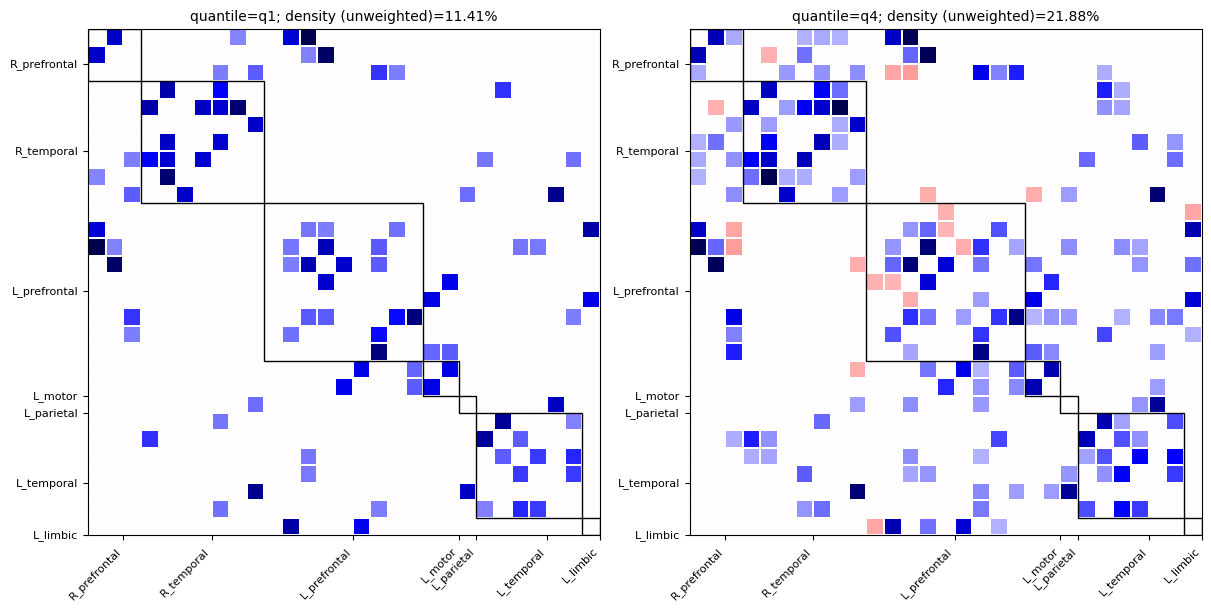

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,6),constrained_layout=True)
for score_id, quantile_key in enumerate(['q1','q4']):
    
    ax_id = score_id
    graph = content[quantile_key]['avg_graph']
    graph = (-1)*(graph + graph.transpose())/2
    
    density_unw = (np.abs(graph)>threshold).sum()/(graph.shape[0]**2)
    density_w = (np.abs(graph)*(np.abs(graph)>threshold)).sum()/(graph.shape[0]**2)

    get_heatmap(graph, axs[ax_id], rm_diag=True, threshold=threshold)
    axs[ax_id].set_title(f'quantile={quantile_key}; density (unweighted)={density_unw*100:.2f}%', 
                     fontsize=10)

    axs[ax_id].xaxis.set_major_locator(ticker.FixedLocator(content['dict_arr']))
    axs[ax_id].yaxis.set_major_locator(ticker.FixedLocator(content['dict_arr']))
    axs[ax_id].set_xticklabels(labels=np.unique(content['node_labels']), rotation=45, ha='right',fontsize=8)
    axs[ax_id].set_yticklabels(labels=np.unique(content['node_labels']), rotation=0, ha='right',fontsize=8)
    
    for ix, idxv in enumerate(content['vh_arr']):
        rect = patches.Rectangle((idxv, idxv), content['size_arr'][ix],
                                 content['size_arr'][ix], linewidth=1, edgecolor='black', facecolor='none')
        axs[ax_id].add_patch(rect)

fig.savefig(f'{output_dir}/{data_str}_{region_key}_q1_vs_q4.png')